### Sundqvist Scheme

How about we fit the Sundqvist model where we fit the tuning parameters to the data? <br>
We let the parameters depend on whether they are taken over land or over the sea.

In this version, we find the optimal set of hyperparameters automatically!

In [1]:
# Won't produce any output inside a SLURM job for some reason

In [3]:
import os
import sys
import time
import json
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.callbacks import LambdaCallback

sys.path.insert(0, '/home/b/b309170/workspace_icon-ml/symbolic_regression/')
from functions import evaluate_sundqvist
from functions import append_dict_to_json

sys.path.insert(0, '/home/b/b309170/my_work/sherpa/')
import sherpa

# Added to the PDF name
ran = np.random.randint(10**3)
print(ran)

seed = 7
np.random.seed(seed)

outfile = '/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_results/best_hyperparameters.json'
outfile_text = '/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_results/all_results.txt'

ImportError: dlopen: cannot load any more object with static TLS

In [3]:
# Load columns of data
folder_data = '/home/b/b309170/workspace_icon-ml/symbolic_regression/data/'

input_train = np.load(os.path.join(folder_data, 'input_train_with_deriv.npy'))
input_valid = np.load(os.path.join(folder_data, 'input_valid_with_deriv.npy'))
output_train = np.load(os.path.join(folder_data, 'output_train_with_deriv.npy'))
output_valid = np.load(os.path.join(folder_data, 'output_valid_with_deriv.npy'))

In [4]:
# Features
new_features = ['qv', 'qv_z', 'qv_zz', 'qc', 'qc_z', 'qc_zz', 'qi', 'qi_z', 'qi_zz', 'temp', 'temp_z', 'temp_zz', \
                'pres', 'pres_z', 'pres_zz', 'zg', 'fr_land']

# To locate variables
loc = {}
for i in range(len(new_features)):
    loc[new_features[i]] = i
    
input_train.shape

(100000, 27, 17)

In [5]:
# Add relative humidity
pres_train = input_train[:, :, loc['pres']]
qv = input_train[:, :, loc['qv']]
temp = input_train[:, :, loc['temp']]

T0 = 273.15
r = 0.00263*pres_train*qv*np.exp((17.67*(temp-T0))/(temp-29.65))**(-1)

new_features.append('rh')
input_train = np.append(input_train, np.expand_dims(r, -1), axis=2)

# The same for input_valid
pres_valid = input_valid[:, :, loc['pres']]
qv = input_valid[:, :, loc['qv']]
temp = input_valid[:, :, loc['temp']]

T0 = 273.15
r = 0.00263*pres_valid*qv*np.exp((17.67*(temp-T0))/(temp-29.65))**(-1)

input_valid = np.append(input_valid, np.expand_dims(r, -1), axis=2)

In [6]:
# Add surface pressure to every sample
ps_train = np.expand_dims(np.repeat(np.expand_dims(pres_train[:, -1], -1), 27, axis=1), -1)
ps_valid = np.expand_dims(np.repeat(np.expand_dims(pres_valid[:, -1], -1), 27, axis=1), -1)

new_features.append('ps')
input_train = np.append(input_train, ps_train, axis=2)
input_valid = np.append(input_valid, ps_valid, axis=2)

In [7]:
# Updating loc
loc = {}
for i in range(len(new_features)):
    loc[new_features[i]] = i
    
input_train.shape

(100000, 27, 19)

In [8]:
# Flatten before passing it to LinearRegression()
flattened_input_train = np.reshape(input_train, (-1, len(new_features)))
flattened_input_valid = np.reshape(input_valid, (-1, len(new_features)))
flattened_output_train = np.reshape(output_train, -1)
flattened_output_valid = np.reshape(output_valid, -1)

flattened_input_train.shape

(2700000, 19)

In [9]:
# We split the training data into cells over land vs sea
land_ind = np.where(flattened_input_train[:, loc['fr_land']] > 0.5)[0]
sea_ind = np.where(flattened_input_train[:, loc['fr_land']] <= 0.5)[0]

input_land = flattened_input_train[land_ind]
output_land = flattened_output_train[land_ind]
input_sea = flattened_input_train[sea_ind]
output_sea = flattened_output_train[sea_ind]

In [10]:
# We split the validation data into cells over land vs sea
land_ind = np.where(flattened_input_valid[:, loc['fr_land']] > 0.5)[0]
sea_ind = np.where(flattened_input_valid[:, loc['fr_land']] <= 0.5)[0]

input_land_valid = flattened_input_valid[land_ind]
output_land_valid = flattened_output_valid[land_ind]
input_sea_valid = flattened_input_valid[sea_ind]
output_sea_valid = flattened_output_valid[sea_ind]

In [11]:
len(land_ind)/flattened_input_train.shape[0]

0.25996

### Fitting hyperparameters
Original ones: $r_{sat} = 1, r_{0, top} = 0.8, r_{0, surf} = 0.968, n = 2$

### Create custom layer

In [12]:
class Sundq_Layer(tf.keras.layers.Layer):

    # These are the output units
    def __init__(self, units=1):
        super(Sundq_Layer, self).__init__()
        self.units = units

    def build(self, input_shape):  # Create the state of the layer (weights)
        
        # Initializing with the original values
        # rsat must always be greater than r0_top and r0_surf! How could we enforce this? (*)
        rsat_init = tf.constant_initializer(1)
        r0_top_init = tf.constant_initializer(0.8)
        r0_surf_init = tf.constant_initializer(0.968)
        n_init = tf.constant_initializer(2)  
    
        self.rsat = tf.Variable(name='rsat', initial_value=rsat_init(shape=(1, self.units), dtype='float32'), trainable=True)
        self.r0_top = tf.Variable(name='r0_top', initial_value=r0_top_init(shape=(1, self.units), dtype='float32'), trainable=True)
        self.r0_surf = tf.Variable(name='r0_surf', initial_value=r0_surf_init(shape=(1, self.units), dtype='float32'), trainable=True)
        self.n = tf.Variable(name='n', initial_value=n_init(shape=(1, self.units), dtype='float32'), trainable=True)

    def call(self, inputs):  # Defines the computation from inputs to outputs
        ps = inputs[:, 0]
        p = inputs[:, 1]
        rh = inputs[:, 2]
        
        r0 = self.r0_top + (self.r0_surf - self.r0_top)*tf.exp(1-(ps/p)**self.n)
        
        # div < 0, only if rsat < r0. But this goes against (*)
        div = (tf.minimum(rh, self.rsat) - self.rsat)/(r0 - self.rsat)
        
        # tf.sqrt is tricky, because its gradient in 0 is infinite!
        c = 1 - tf.sqrt(tf.maximum(div, 1e-9)) # in [0,1]
        
        # If rh > r0 we return c, otherwise we set it to 0
        c_out = tf.maximum(tf.sign(rh - r0), 0)*c
        
        return 100*tf.transpose(c)

**Land**

I will use the same set of hyperparameters for the sea.

In [13]:
parameters = [sherpa.Continuous('lrinit', [1e-9, 1e-1], 'log'),
              sherpa.Ordinal('batch_size', [32, 64, 128, 256]),
              sherpa.Choice('optimizer', [tf.keras.optimizers.SGD, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adagrad, \
                                         tf.keras.optimizers.Adadelta, tf.keras.optimizers.Adam, tf.keras.optimizers.Adamax])]

In [14]:
alg = sherpa.algorithms.RandomSearch() 
study = sherpa.Study(parameters=parameters, algorithm=alg, lower_is_better=True)

INFO:sherpa.core:
-------------------------------------------------------
SHERPA Dashboard running. Access via
http://10.50.13.245:8880 if on a cluster or
http://localhost:8880 if running locally.
-------------------------------------------------------


 * Serving Flask app 'sherpa.app.app' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [ ]:
for trial in study:
    sundq_layer = Sundq_Layer()
    model = tf.keras.models.Sequential(sundq_layer)
    
    par = trial.parameters
    
    print(par['optimizer'])
    
    optimizer = par['optimizer'](lr=par['lrinit'])
    model.compile(loss='mse', optimizer=optimizer)
    
    # Train the model
    model.fit(input_land[:, [loc['ps'], loc['pres'], loc['rh']]], output_land, batch_size=par['batch_size'],
              epochs=10, verbose=2, 
              validation_data=(input_land_valid[:, [loc['ps'], loc['pres'], loc['rh']]], output_land_valid),
              callbacks=[study.keras_callback(trial, objective_name='val_loss')])
    
    try:
        study.finalize(trial)

        # Write to JSON
        results_dict = study.results.to_dict()
        for i in range(len(results_dict['optimizer'])):
            results_dict['optimizer'][i] = str(results_dict['optimizer'][i])
        append_dict_to_json(results_dict, outfile)

        # Write to csv
        study.save('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_results/')
    except:
        with open('nans.txt', 'a') as file:
            file.write(str(par)+'\n')

<class 'tensorflow.python.keras.optimizer_v2.adadelta.Adadelta'>
Epoch 1/10
10980/10980 - 26s - loss: 17439.2656 - val_loss: 16622.9609
Epoch 2/10
10980/10980 - 25s - loss: 17439.2832 - val_loss: 16622.9609
Epoch 3/10
10980/10980 - 23s - loss: 17439.2441 - val_loss: 16622.9609
Epoch 4/10
10980/10980 - 23s - loss: 17439.1543 - val_loss: 16622.9609
Epoch 5/10
10980/10980 - 24s - loss: 17439.2598 - val_loss: 16622.9609
Epoch 6/10
10980/10980 - 24s - loss: 17439.2129 - val_loss: 16622.9609
Epoch 7/10
10980/10980 - 25s - loss: 17439.2383 - val_loss: 16622.9609
Epoch 8/10
10980/10980 - 24s - loss: 17439.2285 - val_loss: 16622.9609
Epoch 9/10
10980/10980 - 24s - loss: 17439.2695 - val_loss: 16622.9609
Epoch 10/10
10980/10980 - 24s - loss: 17439.2715 - val_loss: 16622.9609
<class 'tensorflow.python.keras.optimizer_v2.adagrad.Adagrad'>
Epoch 1/10
10980/10980 - 25s - loss: 17439.2168 - val_loss: 16622.9609
Epoch 2/10
10980/10980 - 24s - loss: 17439.2402 - val_loss: 16622.9609
Epoch 3/10
10980/10

**Read results**

In [32]:
with open('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/\
sundqvist_results/results.csv', 'r') as file: 
    df = pd.read_csv(file)

In [33]:
objective = []

for k in range(df.shape[0]):
    objective.append(df.at[k, 'Objective'])

In [34]:
best_ind = np.nanargmin(objective)
print(df.loc[best_ind])
df.at[best_ind, 'optimizer']

Trial-ID                                                     88
Status                                             INTERMEDIATE
Iteration                                                     0
batch_size                                                   32
lrinit                                                0.0523026
optimizer     <class 'tensorflow.python.keras.optimizer_v2.a...
Objective                                               393.734
Name: 952, dtype: object


"<class 'tensorflow.python.keras.optimizer_v2.adagrad.Adagrad'>"

Objective vs initial learning rate

In [35]:
model_parameters = []
objective = []

for k in range(df.shape[0]):
    model_parameters.append(df.at[k, 'lrinit'])
    objective.append(df.at[k, 'Objective'])

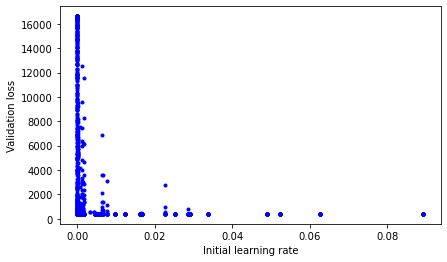

In [36]:
fig = plt.figure()
fig.set_figwidth(15)

ax = fig.add_subplot(1,2,1)
plt.figure(1, figsize = (8,8))
plt.xlabel('Initial learning rate')
plt.ylabel('Validation loss')
plt.plot(model_parameters, objective, 'b.')

**Was trying out GridSearchCV**

But I don't know how to terminate it. Also there strangely little output.

In [ ]:
# from sklearn.model_selection import GridSearchCV

# def create_model(optimizer, lr):
#     sundq_layer = Sundq_Layer()
#     model = tf.keras.models.Sequential(sundq_layer)
#     optimizer = optimizer(learning_rate=lr)
#     model.compile(optimizer=optimizer, loss='mse', metrics=["accuracy"])
#     return model

# model = KerasClassifier(build_fn=create_model, verbose=0)

# # Define the grid search parameters
# optimizer = [tf.keras.optimizers.SGD, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adagrad,\
#              tf.keras.optimizers.Adadelta, tf.keras.optimizers.Adam, tf.keras.optimizers.Adamax]
# lr = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
# epochs = [10, 50]
# batch_size = [32, 64, 128, 256]

# # Silence warnings
# import logging
# logging.getLogger("tensorflow").setLevel(logging.ERROR)

# # Hyperparameter search
# param_grid = dict(optimizer=optimizer, lr=lr, epochs=epochs, batch_size=batch_size)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=2)
# grid_result = grid.fit(input_land[:, [loc['ps'], loc['pres'], loc['rh']]], output_land)

# # Write best results to JSON
# with open(outfile, 'w') as file:
#     d_out = grid_result.best_params_.copy()
#     d_out['optimizer'] = str(d_out['optimizer'])
#     json.dump(d_out, file)
    
# # Dump all results to txt
# with open(outfile_text, 'w') as file:
#     for key, value in grid_result.cv_results_.items():
#         file.write('%s: %s'%(key, str(value)))